In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)

    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig('scaling.png')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    #ax3.set_ylim([0, 2.25])
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig('cost.pdf')

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=16)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  HF(REDUX)  \
0   16     8      128      1         1        2        2613.0     1.1888   
2   32     8      256      2         1        2        1368.0     2.5901   
1   48     8      384      3         1        2         934.0     3.3677   

   GW(REDUX)  IO_and_Messaging_switch  ...        Xo  DIPOLE_transverse  \
0     0.5093                   0.0004  ...  860.0000          1330.0000   
2     0.4938                   0.0004  ...  466.2198           676.0000   
1     1.0115                   0.0006  ...  315.7321           458.3006   

     Dipoles  gpu  ideal   speedup  efficiency  Self energy    Other    node_h  
0  1332.0000    8    1.0  1.000000  100.000000     394.8066  23.4801  0.725833  
2   677.0000   16    2.0  1.910088   95.504386     202.0040  20.4061  0.760000  
1   460.7711   24    3.0  2.797645   93.254818     135.8518  19.2187  0.778333  

[3 rows x 52 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles        Xo       X  Self energy    Other
0   16        2613.0  1332.0000  860.0000  2.7133     394.8066  23.4801
2   32        1368.0   677.0000  466.2198  2.3701     202.0040  20.4061
1   48         934.0   460.7711  315.7321  2.4263     135.8518  19.2187

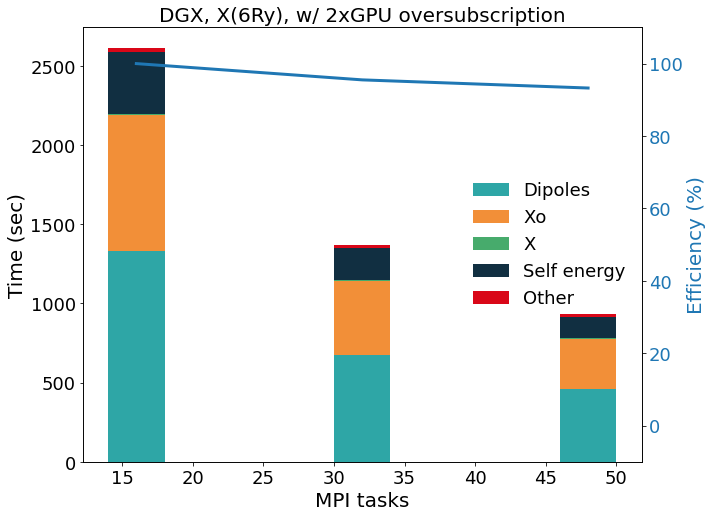

In [9]:
build_scaling_plot(scaling=scaling, pile=pile, colors=colors, bar_width=4, efficiency=True,
                   legend_loc='center right', title=r'DGX, X(6Ry), w/ 2xGPU oversubscription')

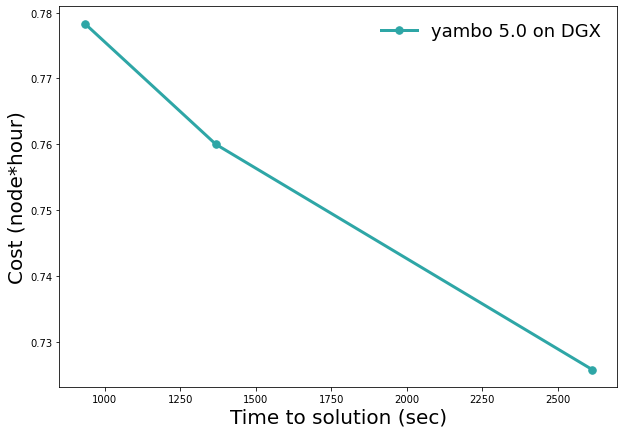

In [10]:
build_cost_plot(scaling=scaling, label='yambo 5.0 on DGX')